In [20]:
import pickle
import networkx as nx
import geopandas as gpd
import shapely
from tqdm import tqdm
from shapely import wkt
import pickle
import osmnx as ox
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

In [ ]:
#check coommit

In [21]:
mo = gpd.read_file('Границы_только_МР_Границы_ЛО_Без_воды.geojson').drop(index=5).reset_index()
cities18 = gpd.read_file('17(18)_centers.geojson')
graph = nx.read_graphml('uds_graph_with_reg.graphml')

In [23]:
def convert_node_names_to_tuple(graph):
    node_mapping = {node: str(node) for node in graph.nodes()}
    G_int = nx.relabel_nodes(graph, node_mapping)
    return G_int


In [24]:
import momepy
import math
from shapely import Point


def add_nearest_node_to_graph(graph, gdf):
    gdf['center'] = None
    for idx,feature in gdf.iterrows():
        
        geometry = feature['geometry']
        point = geometry
        nearest_node = None
        min_distance = float('inf')
        # Находим ближайший узел на графе к точке
        for node, data in graph.nodes(data=True):

            node_point = Point(ast.literal_eval(node)[0], ast.literal_eval(node)[1])

            distance = node_point.distance(point)
            if distance < min_distance:
                min_distance = distance
                nearest_node = node
        gdf.at[idx, 'center'] = str(nearest_node)
        # Добавляем атрибут с именем в найденный ближайший узел
        if nearest_node is not None:
            name = feature['name18']
            graph.nodes[nearest_node]['name'] = name
    return graph


def find_nearest_linestrings_join_nearest(gdf, point):
    point_gdf = gpd.GeoDataFrame(geometry=[Point(ast.literal_eval(point))], crs=gdf.crs)
    nearest_joined = gpd.sjoin_nearest(point_gdf, gdf)
    nearest_linestrings = gdf.loc[nearest_joined['index_right0']]['geometry']

    return nearest_linestrings


def find_shortest(source,targets):
    mi = float('inf')
    l = None
    for target,line in targets:
        
        try:
            cur = nx.shortest_path_length(graph, source=source, target=target, weight="length_meter")
        except:
            cur = float('inf')
        if cur < mi:
            mi = cur
            l = line
    return mi,l


def accessibility_reg(graph,mo,cities18):
    
    for e1,e2,data in graph.edges(data=True):
        data['geometry'] = wkt.loads(str(data['geometry']))
    joined = momepy.nx_to_gdf(graph,points=False)

    cities18 = cities18.to_crs(joined.crs)
    mo = mo.to_crs(cities18.crs)
    
    graph = add_nearest_node_to_graph(graph, cities18)  
    graph = convert_node_names_to_tuple(graph)
    exploded_gdf = joined.explode()
    exploded_gdf['geometry'] = exploded_gdf['geometry'].apply(lambda geom: geom if geom.type == 'LineString' else geom[0])
    spisak = []
    for idx,row in cities18.iterrows():
        temp = find_nearest_linestrings_join_nearest(exploded_gdf[exploded_gdf['REG_STATUS']==1], row['center']).reset_index()
        targets = []
        for i in range(len(temp)):
            if graph.has_node(str(temp.iloc[i]['geometry'].coords[0])):
                targets.append((str(temp.iloc[i]['geometry'].coords[0]),   temp.iloc[i]['geometry']))
            if graph.has_node(str(temp.iloc[i]['geometry'].coords[-1])):
                targets.append((str(temp.iloc[i]['geometry'].coords[-1]),temp.iloc[i]['geometry']))
        
        res = find_shortest(row['center'],targets)
        spisak.append((res))
    
    df = pd.DataFrame({'dost': [s[0]/1000 for s in spisak]})
    mo = pd.concat([mo, df], axis=1)

    cmap = 'RdYlGn_r'
    ax = mo.plot(column='dost', cmap=cmap, figsize=(16, 8), legend=True)
    cities18.to_crs(mo.crs).geometry.plot(ax=ax, markersize=10, color='blue', marker='o')

    ax.set_axis_off()
    plt.title('Удаленность админ. центра от федеральной трассы, км')
    plt.savefig('dist_fed.png', dpi=600)
    plt.show()

/var/folders/ch/1hzm9xv12jg458kt9c3nl6_h0000gn/T/ipykernel_17763/3218148948.py:70: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  exploded_gdf = joined.explode()
/var/folders/ch/1hzm9xv12jg458kt9c3nl6_h0000gn/T/ipykernel_17763/3218148948.py:71: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  exploded_gdf['geometry'] = exploded_gdf['geometry'].apply(lambda geom: geom if geom.type == 'LineString' else geom[0])


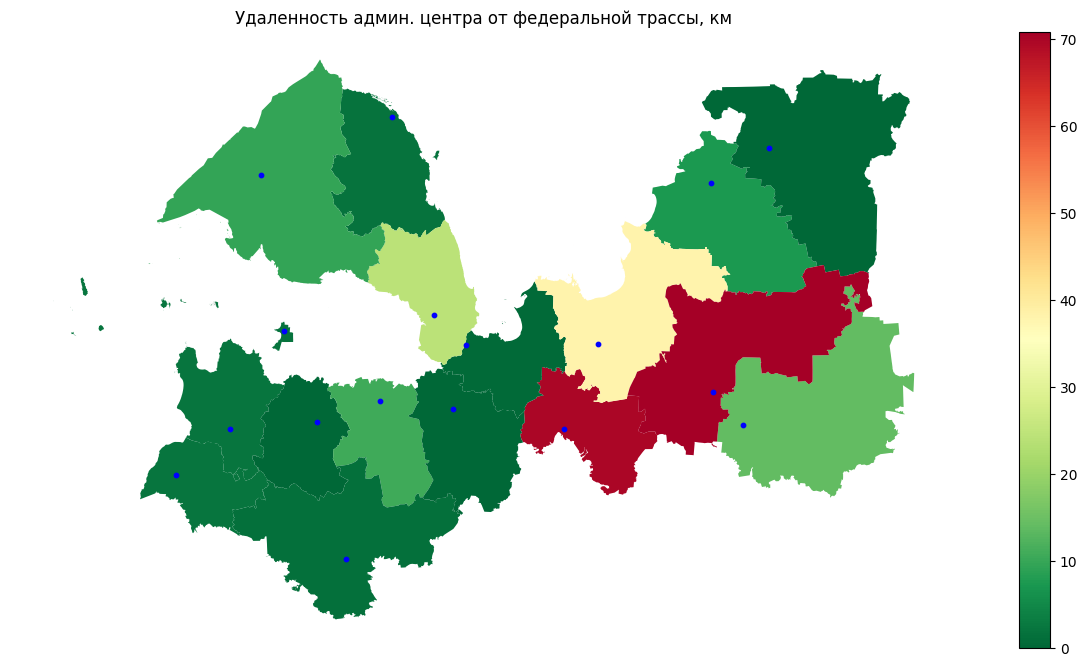

In [25]:
accessibility_reg(graph,mo,cities18)